<a href="https://www.kaggle.com/code/rameezmeerasahib/titanic-survival-prediction?scriptVersionId=233185957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Titanic Survival Prediction**

**Using XGBoost & Advanced Feature Engineering**

**1. Introduction**

In this notebook, we’ll develop a machine learning pipeline for predicting which passengers survived the Titanic disaster. We will:

1. Perform data cleaning and feature engineering
2. Explore advanced techniques such as Title extraction from passenger names
3. Leverage XGBoost, a powerful gradient boosting framework known to excel on tabular data
4. Fine-tune the model using GridSearchCV (or a variant)

The final output will be a CSV file (my_submission.csv) with our predictions on the test set, ready for Kaggle submission.

**2. Data Loading**

train.csv and test.csv are already available in our Kaggle environment under an “Input” folder named something like ../input/titanic/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost (installed by default on Kaggle)
from xgboost import XGBClassifier

# Load the data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Quick look
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
train_df.head()


Train Shape: (891, 12)
Test Shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Notes:**

* train_df includes the Survived column (our target) and has 891 rows.

* test_df does not include the Survived column; it has 418 rows. We must predict who survived among these 418 passengers.

**3. Exploratory Data Analysis (EDA)**
A brief EDA helps us identify missing values, distribution of features, and potential transformations.

**3.1 Overview**

In [2]:
train_df.info()

train_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


**Look for:**

* Missing Age (common in Titanic)

* Largely missing Cabin

* Possibly missing Embarked for some passengers

**3.2 Target Distribution**

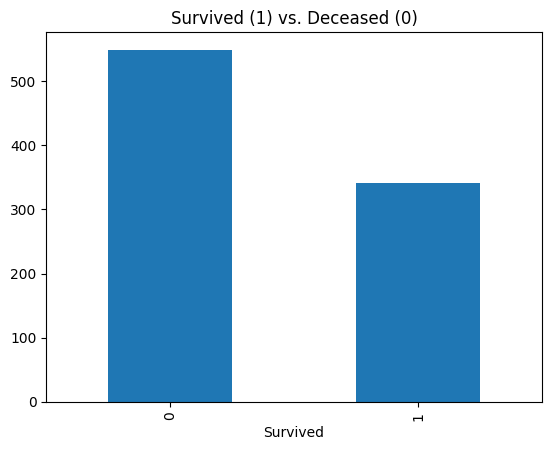

Overall Survival Rate: 38.38%


In [3]:
train_df['Survived'].value_counts().plot(kind='bar', title='Survived (1) vs. Deceased (0)')
plt.show()

survival_rate = 100 * train_df['Survived'].mean()
print(f"Overall Survival Rate: {survival_rate:.2f}%")


*We can also examine how survival correlates with other features (like Sex, Pclass, etc.):*****

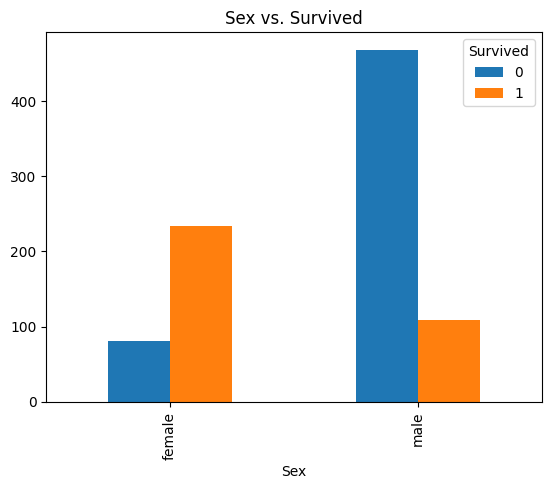

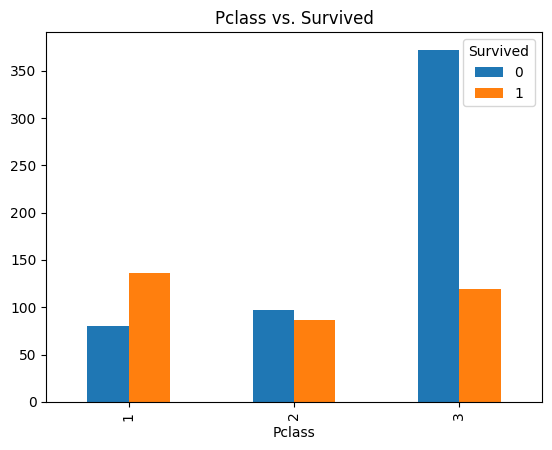

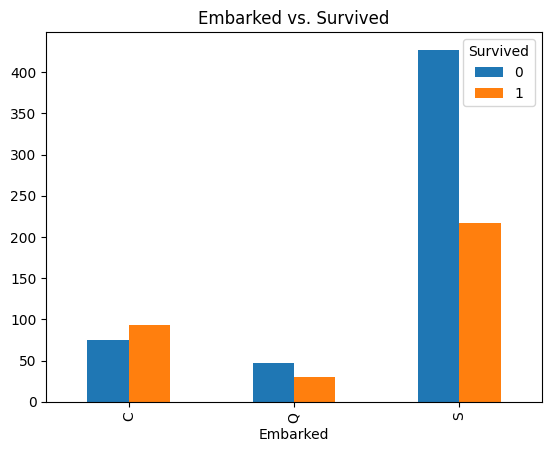

In [4]:
pd.crosstab(train_df['Sex'], train_df['Survived']).plot(kind='bar', title='Sex vs. Survived')
plt.show()

pd.crosstab(train_df['Pclass'], train_df['Survived']).plot(kind='bar', title='Pclass vs. Survived')
plt.show()

pd.crosstab(train_df['Embarked'], train_df['Survived']).plot(kind='bar', title='Embarked vs. Survived')
plt.show()


**Observations often show that females and higher classes have a higher survival rate.**

**4. Data Cleaning & Feature Engineering**

**4.1 Combine Data for Consistent Processing**

It’s often simpler to combine train and test sets, apply transformations, then split them back. This ensures consistent encoding/imputations.

In [5]:
# Keep track of test passenger IDs, needed for final submission
test_passenger_ids = test_df['PassengerId']

# Add a temporary 'Survived' column to test for combining
test_df['Survived'] = np.nan

# Combine
full_df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
print("Combined data shape:", full_df.shape)


Combined data shape: (1309, 12)


**4.2 Missing Values**

Check how many are missing:

In [6]:
full_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

**4.2.1 Embarked**

If Embarked is missing (sometimes a few), fill with the most common port:

In [7]:
embarked_mode = full_df['Embarked'].dropna().mode()[0]  # 'S' typically
print("Adding "+embarked_mode+ " as Embarked mode for missing rows")
full_df['Embarked'].fillna(embarked_mode, inplace=True)

Adding S as Embarked mode for missing rows


**4.2.2 Fare**

If Fare is missing (often just 1 passenger in test), fill with the median:

In [8]:
fare_median = full_df['Fare'].median()
print("Adding "+str(fare_median)+ " as Median fare for missing rows")
full_df['Fare'].fillna(fare_median, inplace=True)

Adding 14.4542 as Median fare for missing rows


**4.2.3 Age**

We’ll impute missing Age by grouping (Sex, Pclass) medians (Lets go with popular Titanic approach):

In [9]:
grouped_median_age = full_df.groupby(['Sex','Pclass'])['Age'].median()

print("Adding "+str(grouped_median_age)+ " as Median age (grouped by Sex & PcClass) for missing rows")

def fill_age(row):
    if pd.isnull(row['Age']):
        return grouped_median_age[(row['Sex'], row['Pclass'])]
    else:
        return row['Age']

full_df['Age'] = full_df.apply(fill_age, axis=1)


Adding Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64 as Median age (grouped by Sex & PcClass) for missing rows


**4.3 Feature Engineering**

**4.3.1 Extracting Titles from Name**

A known powerful trick is to parse titles (Mr, Mrs, Miss, Master, Rare) from the passenger Name.

In [10]:
def get_title(name):
    return name.split(',')[1].split('.')[0].strip()

full_df['Title'] = full_df['Name'].apply(get_title)

# Group some rare titles together
rare_titles = ['Dr','Rev','Col','Major','Capt','Countess','Don','Sir','Jonkheer','Dona','Lady']
full_df['Title'] = full_df['Title'].replace(rare_titles, 'Rare')


**4.3.2 Family Size**

Sometimes combining SibSp (siblings/spouses) and Parch (parents/children) plus 1 for the passenger themselves can help:

In [11]:
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1

**4.3.3 Convert Categorical to Numeric**

* Sex: female = 1, male = 0.

* Embarked: one-hot encode.

* Title: one-hot encode.

In [12]:
full_df['Sex'] = full_df['Sex'].map({'male':0, 'female':1})

# One-hot encode Embarked, Title
full_df = pd.get_dummies(full_df, columns=['Embarked','Title'], drop_first=True)

**4.3.4 (Optional) Cabin Feature**

Most Cabin entries are missing; a simple approach is “HasCabin = 1/0.”

In [13]:
full_df['HasCabin'] = full_df['Cabin'].notnull().astype(int)

**4.4 Drop Unnecessary Columns**

Remove columns that are less likely to help or that have been replaced by new features.

In [14]:
drop_cols = ['PassengerId','Name','Ticket','Cabin']

full_df.drop(columns=drop_cols, inplace=True, errors='ignore')

full_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_Q,Embarked_S,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess,HasCabin
0,0.0,3,0,22.0,1,0,7.2500,2,False,True,False,False,False,True,False,False,False,False,0
1,1.0,1,1,38.0,1,0,71.2833,2,False,False,False,False,False,False,True,False,False,False,1
2,1.0,3,1,26.0,0,0,7.9250,1,False,True,True,False,False,False,False,False,False,False,0
3,1.0,1,1,35.0,1,0,53.1000,2,False,True,False,False,False,False,True,False,False,False,1
4,0.0,3,0,35.0,0,0,8.0500,1,False,True,False,False,False,True,False,False,False,False,0


**5. Split Data Back**
   
Recall the original train set has 891 rows.

In [15]:
# Extract the portion that belongs to the original train
df_train = full_df.iloc[:len(train_df)].copy()
df_test = full_df.iloc[len(train_df):].copy()

X = df_train.drop('Survived', axis=1)
y = df_train['Survived'].astype(int)

X_test = df_test.drop('Survived', axis=1)

**6. Train / Validation Split**
   
Create a small validation set to gauge model performance.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (712, 18) Val: (179, 18)


**7. XGBoost Model Training**
   
**7.1 Baseline XGBoost**

We start with a simple version:

In [17]:
xgb_baseline = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)
xgb_baseline.fit(X_train, y_train)

val_preds = xgb_baseline.predict(X_val)
baseline_acc = accuracy_score(y_val, val_preds)

print(f"Baseline XGB Accuracy: {baseline_acc:.4f}")
print(confusion_matrix(y_val, val_preds))
print(classification_report(y_val, val_preds))


Baseline XGB Accuracy: 0.8156
[[92 13]
 [20 54]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



**7.2 Hyperparameter Tuning**

XGBoost has many parameters. Let’s do a small GridSearch to find better settings:

In [18]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'subsample': [1.0, 0.8]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.8342460356544864


**Note:**

You can expand or refine this grid. Larger grids = longer runtime.



**7.3 Evaluate Tuned Model**

Let’s check validation accuracy with the best estimator.

In [19]:
best_xgb = grid_search.best_estimator_
val_preds_best = best_xgb.predict(X_val)
val_acc_best = accuracy_score(y_val, val_preds_best)

print(f"Validation Accuracy (Tuned XGB): {val_acc_best:.4f}")
print(confusion_matrix(y_val, val_preds_best))
print(classification_report(y_val, val_preds_best))


Validation Accuracy (Tuned XGB): 0.8045
[[91 14]
 [21 53]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



**8. Train on Full Training Set**
   
Once we’re satisfied with the hyperparameters, we typically retrain on all training data (891 rows) for maximum coverage:

In [20]:
final_xgb = grid_search.best_estimator_
final_xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**9. Predictions on Test Data**
    
Time to produce predictions for the competition. We just call predict on the processed X_test:

In [21]:
test_preds = final_xgb.predict(X_test)
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,  # from original test_df
    'Survived': test_preds.astype(int)
})
print(submission_df)
submission_df.to_csv('my_submission.csv', index=False)
print("Submission file 'my_submission.csv' created!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Submission file 'my_submission.csv' created!
